In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

print(tf.__version__)
datapath = 'data/'
df = pd.read_csv(datapath + 'ibuprofen.csv')

print(df.dtypes.value_counts())
print(df.columns.tolist())
print('length of columns :', len(df.columns.tolist()))
print(df.count())
df.head()

1.12.0
float64    2
object     1
int64      1
dtype: int64
['dateUnix', 'dateIso', 'kgPrice', 'quantity']
length of columns : 4
dateUnix    3978
dateIso     3978
kgPrice     3978
quantity    3978
dtype: int64


,dateUnix,dateIso,kgPrice,quantity
0,1483311600,1/1/2017,15.111767,20000.0
1,1483311600,1/1/2017,12.697010,3000.0
2,1483311600,1/1/2017,9.700000,6500.0
3,1483311600,1/1/2017,11.347700,4000.0
4,1483311600,1/1/2017,9.347750,1000.0


In [4]:
# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])
  
def plot_prediction(original, predicted):
    #fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    # Get subplots
    f, (plt1, plt2, plt3) = plt.subplots(3)
    
    # Get Daily errors
    a = original
    b = predicted
    if(len(original.shape) > 1):
        a = original.reshape(original.shape[0]*original.shape[1])
    
    if(len(predicted.shape) > 1):
        b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
    daily_errors = abs(a - b)
  
    t = 7
    weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
    # Calculate R2 metric
  
    # FROM wikipedia: 
    # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
    # This would occur when the wrong model was chosen.
    
    m = np.mean(a)
    ss_tot = np.sum(np.power((a - m), 2))
    ss_res = np.sum(np.power((a - b), 2))
    r_square = 1 - (ss_res / ss_tot)
    r_square = "{0:.4f}".format(r_square)
    
    mape = calc_mape(b, a)
  
    # Get weekly errors
    # plot original vs predicted  
    plt1.plot(original, 
           color='black', 
           label = 'Original data') 
    
    plt1.plot(predicted,
           color='blue', 
           label = 'Predicted data')

    # PLOT DAILY ERRORS
    plt2.plot(daily_errors, color='red')

    # PLOT WEEKLY ERRORS
    for i, e in enumerate(weekly_errors):
        plt3.bar(x=i*7, height=e, width=5, color='red')

    plt1.set_title('Actual and Predicted - R2: '+str(r_square) + ' - MAPE:'+str(mape))  
    plt2.set_title('Daily Errors')
    plt3.set_title('Weekly Errors')
  
    # IF YOU ARE USING COLAB, USE THIS:
    plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
    # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
    # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
    
    plt.show()

Text(0.5,1,'quantity vs kgPrice')

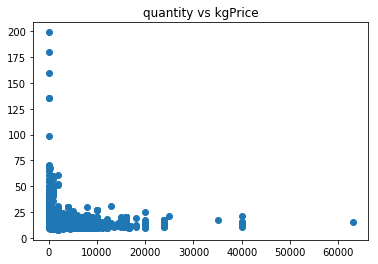

In [5]:
plt.scatter(df.quantity, df.kgPrice)
plt.title('quantity vs kgPrice')

Text(0.5,1,'dateUnix vs kgPrice')

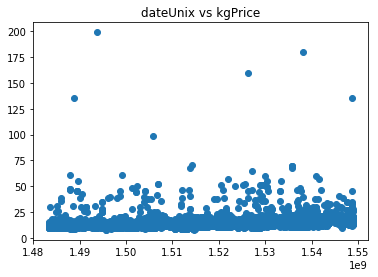

In [6]:
plt.scatter(df.dateUnix, df.kgPrice)
plt.title('dateUnix vs kgPrice')

Text(0.5,1,'dateUnix vs quantity')

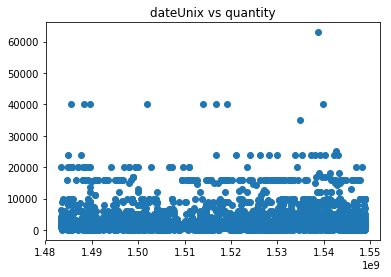

In [7]:
plt.scatter(df.dateUnix, df.quantity)
plt.title('dateUnix vs quantity')

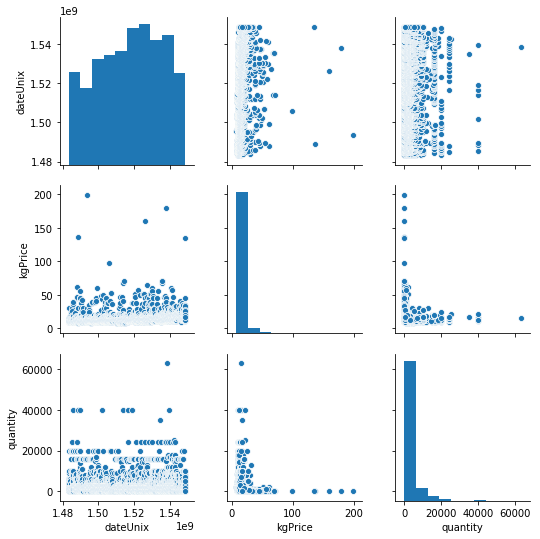

In [8]:
sns.pairplot(df)

In [9]:
dataset = df.copy()
dataset = dataset.drop("dateIso", axis=1)
dataset.head()

,dateUnix,kgPrice,quantity
0,1483311600,15.111767,20000.0
1,1483311600,12.697010,3000.0
2,1483311600,9.700000,6500.0
3,1483311600,11.347700,4000.0
4,1483311600,9.347750,1000.0


In [10]:
def fn(group):
    group['weighted_avg_kgprice'] = group['kgPrice'] * group['quantity'] / group['quantity'].sum()
    return group

d_agg = {'weighted_avg_kgprice':'sum', 
         'quantity':'sum'
        }

dataset_weighted = dataset.groupby('dateUnix', sort=False).apply(fn).groupby('dateUnix').agg(d_agg)
dataset_weighted.head()
#dataset_weighted

#print(dataset.groupby('dateUnix', sort=False).apply(fn))

,weighted_avg_kgprice,quantity
dateUnix,,
1483311600,12.405626,46350.0
1483398000,11.801926,2300.0
1483484400,11.687077,15550.0
1483657200,19.074012,9850.0
1483743600,13.525167,17850.0


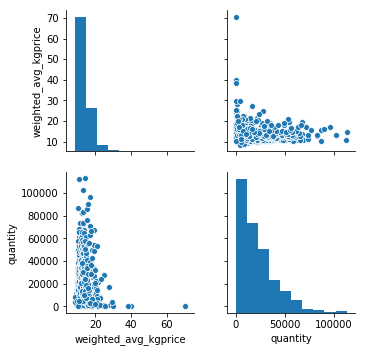

In [11]:
sns.pairplot(dataset_weighted)

In [12]:
features = dataset_weighted.drop('weighted_avg_kgprice', 1)
labels = dataset_weighted['weighted_avg_kgprice']
#features
#labels

In [13]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state = 0, shuffle=False)
#labels_test

In [14]:
train_stats = features_train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
quantity,543.0,21464.823759,19001.548458,4.0,7000.0,16025.0,30235.0,112850.0


In [15]:
test_stats = features_test.describe()
test_stats = test_stats.transpose()
test_stats

,count,mean,std,min,25%,50%,75%,max
quantity,61.0,21692.213115,20089.233272,50.0,7000.0,16250.0,29975.0,96120.0


In [16]:
# used data standardization = (x - mean)/std
# data normalization = (x-min)/(max-min) 
def norm(x, stats):
    return (x - stats['min'])/(stats['max'] - stats['min'])

In [17]:
normed_train_data = norm(features_train, train_stats)
normed_test_data = norm(features_test, test_stats)

In [18]:
normtrain = normed_train_data.describe()
normtrain = normtrain.transpose()
normtrain

,count,mean,std,min,25%,50%,75%,max
quantity,543.0,0.190178,0.168385,0.0,0.061996,0.141972,0.267896,1.0


In [19]:
normtest = normed_test_data.describe()
normtest = normtest.transpose()
normtest

,count,mean,std,min,25%,50%,75%,max
quantity,61.0,0.225275,0.20911,0.0,0.072343,0.168627,0.311492,1.0


In [20]:
def build_model():
    #create model
    model = keras.Sequential() 
    
    #get number of columns in training data 
    n_cols = normed_train_data.shape[1]
    
    #add model layers
    model.add(layers.Dense(512, activation='relu', input_shape=(n_cols,)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1))

    optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [21]:
model = build_model()

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 789,505
Trainable params: 789,505
Non-trainable params: 0
_________________________________________________________________


In [23]:
save_model_dir = 'models/'
model_filename = 'regression_basemodel_ibuprofen_weightedavg_norm.h5'

In [24]:
checkpoint = ModelCheckpoint(filepath=save_model_dir + model_filename, verbose=1, save_best_only=True)
history = model.fit(normed_train_data, labels_train, epochs=1000, batch_size=50, verbose=0, callbacks=[checkpoint], validation_split=0.2)


Epoch 00001: val_loss improved from inf to 250.23184, saving model to models/regression_basemodel_ibuprofen_weightedavg_norm.h5

Epoch 00002: val_loss improved from 250.23184 to 247.12083, saving model to models/regression_basemodel_ibuprofen_weightedavg_norm.h5

Epoch 00003: val_loss improved from 247.12083 to 241.78702, saving model to models/regression_basemodel_ibuprofen_weightedavg_norm.h5

Epoch 00004: val_loss improved from 241.78702 to 232.53987, saving model to models/regression_basemodel_ibuprofen_weightedavg_norm.h5

Epoch 00005: val_loss improved from 232.53987 to 216.81671, saving model to models/regression_basemodel_ibuprofen_weightedavg_norm.h5

Epoch 00006: val_loss improved from 216.81671 to 191.52878, saving model to models/regression_basemodel_ibuprofen_weightedavg_norm.h5

Epoch 00007: val_loss improved from 191.52878 to 154.58273, saving model to models/regression_basemodel_ibuprofen_weightedavg_norm.h5

Epoch 00008: val_loss improved from 154.58273 to 108.45056, 

Epoch 00090: val_loss did not improve from 15.72251

Epoch 00091: val_loss did not improve from 15.72251

Epoch 00092: val_loss did not improve from 15.72251

Epoch 00093: val_loss did not improve from 15.72251

Epoch 00094: val_loss did not improve from 15.72251

Epoch 00095: val_loss did not improve from 15.72251

Epoch 00096: val_loss did not improve from 15.72251

Epoch 00097: val_loss did not improve from 15.72251

Epoch 00098: val_loss did not improve from 15.72251

Epoch 00099: val_loss improved from 15.72251 to 15.25822, saving model to models/regression_basemodel_ibuprofen_weightedavg_norm.h5

Epoch 00100: val_loss did not improve from 15.25822

Epoch 00101: val_loss did not improve from 15.25822

Epoch 00102: val_loss did not improve from 15.25822

Epoch 00103: val_loss did not improve from 15.25822

Epoch 00104: val_loss did not improve from 15.25822

Epoch 00105: val_loss did not improve from 15.25822

Epoch 00106: val_loss did not improve from 15.25822

Epoch 00107: val_lo


Epoch 00240: val_loss did not improve from 14.32399

Epoch 00241: val_loss did not improve from 14.32399

Epoch 00242: val_loss did not improve from 14.32399

Epoch 00243: val_loss did not improve from 14.32399

Epoch 00244: val_loss did not improve from 14.32399

Epoch 00245: val_loss did not improve from 14.32399

Epoch 00246: val_loss did not improve from 14.32399

Epoch 00247: val_loss did not improve from 14.32399

Epoch 00248: val_loss did not improve from 14.32399

Epoch 00249: val_loss did not improve from 14.32399

Epoch 00250: val_loss did not improve from 14.32399

Epoch 00251: val_loss did not improve from 14.32399

Epoch 00252: val_loss did not improve from 14.32399

Epoch 00253: val_loss did not improve from 14.32399

Epoch 00254: val_loss did not improve from 14.32399

Epoch 00255: val_loss did not improve from 14.32399

Epoch 00256: val_loss did not improve from 14.32399

Epoch 00257: val_loss did not improve from 14.32399

Epoch 00258: val_loss did not improve from 14


Epoch 00397: val_loss did not improve from 13.62837

Epoch 00398: val_loss did not improve from 13.62837

Epoch 00399: val_loss did not improve from 13.62837

Epoch 00400: val_loss did not improve from 13.62837

Epoch 00401: val_loss did not improve from 13.62837

Epoch 00402: val_loss did not improve from 13.62837

Epoch 00403: val_loss did not improve from 13.62837

Epoch 00404: val_loss did not improve from 13.62837

Epoch 00405: val_loss did not improve from 13.62837

Epoch 00406: val_loss did not improve from 13.62837

Epoch 00407: val_loss did not improve from 13.62837

Epoch 00408: val_loss did not improve from 13.62837

Epoch 00409: val_loss did not improve from 13.62837

Epoch 00410: val_loss did not improve from 13.62837

Epoch 00411: val_loss did not improve from 13.62837

Epoch 00412: val_loss did not improve from 13.62837

Epoch 00413: val_loss did not improve from 13.62837

Epoch 00414: val_loss did not improve from 13.62837

Epoch 00415: val_loss did not improve from 13

Epoch 00554: val_loss did not improve from 13.62837

Epoch 00555: val_loss did not improve from 13.62837

Epoch 00556: val_loss did not improve from 13.62837

Epoch 00557: val_loss did not improve from 13.62837

Epoch 00558: val_loss did not improve from 13.62837

Epoch 00559: val_loss did not improve from 13.62837

Epoch 00560: val_loss did not improve from 13.62837

Epoch 00561: val_loss did not improve from 13.62837

Epoch 00562: val_loss did not improve from 13.62837

Epoch 00563: val_loss did not improve from 13.62837

Epoch 00564: val_loss did not improve from 13.62837

Epoch 00565: val_loss did not improve from 13.62837

Epoch 00566: val_loss did not improve from 13.62837

Epoch 00567: val_loss did not improve from 13.62837

Epoch 00568: val_loss did not improve from 13.62837

Epoch 00569: val_loss did not improve from 13.62837

Epoch 00570: val_loss did not improve from 13.62837

Epoch 00571: val_loss did not improve from 13.62837

Epoch 00572: val_loss did not improve from 13.

Epoch 00712: val_loss did not improve from 13.62837

Epoch 00713: val_loss did not improve from 13.62837

Epoch 00714: val_loss did not improve from 13.62837

Epoch 00715: val_loss did not improve from 13.62837

Epoch 00716: val_loss did not improve from 13.62837

Epoch 00717: val_loss did not improve from 13.62837

Epoch 00718: val_loss did not improve from 13.62837

Epoch 00719: val_loss did not improve from 13.62837

Epoch 00720: val_loss did not improve from 13.62837

Epoch 00721: val_loss did not improve from 13.62837

Epoch 00722: val_loss did not improve from 13.62837

Epoch 00723: val_loss did not improve from 13.62837

Epoch 00724: val_loss did not improve from 13.62837

Epoch 00725: val_loss did not improve from 13.62837

Epoch 00726: val_loss did not improve from 13.62837

Epoch 00727: val_loss did not improve from 13.62837

Epoch 00728: val_loss did not improve from 13.62837

Epoch 00729: val_loss did not improve from 13.62837

Epoch 00730: val_loss did not improve from 13.


Epoch 00869: val_loss did not improve from 13.62837

Epoch 00870: val_loss did not improve from 13.62837

Epoch 00871: val_loss did not improve from 13.62837

Epoch 00872: val_loss did not improve from 13.62837

Epoch 00873: val_loss did not improve from 13.62837

Epoch 00874: val_loss did not improve from 13.62837

Epoch 00875: val_loss did not improve from 13.62837

Epoch 00876: val_loss did not improve from 13.62837

Epoch 00877: val_loss did not improve from 13.62837

Epoch 00878: val_loss did not improve from 13.62837

Epoch 00879: val_loss did not improve from 13.62837

Epoch 00880: val_loss did not improve from 13.62837

Epoch 00881: val_loss improved from 13.62837 to 13.32981, saving model to models/regression_basemodel_ibuprofen_weightedavg_norm.h5

Epoch 00882: val_loss did not improve from 13.32981

Epoch 00883: val_loss did not improve from 13.32981

Epoch 00884: val_loss did not improve from 13.32981

Epoch 00885: val_loss did not improve from 13.32981

Epoch 00886: val_l

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,16.144496,3.039333,16.144496,10.881558,1.638990,10.881558,995
996,15.423520,2.896676,15.423520,11.016687,1.608209,11.016687,996
997,15.094921,2.849139,15.094921,11.003373,1.670489,11.003373,997
998,16.184088,3.025934,16.184088,11.129617,1.649404,11.129617,998
999,13.361244,2.604102,13.361244,10.866256,1.675649,10.866256,999


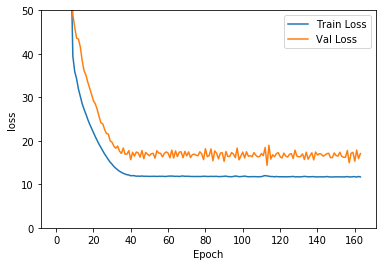

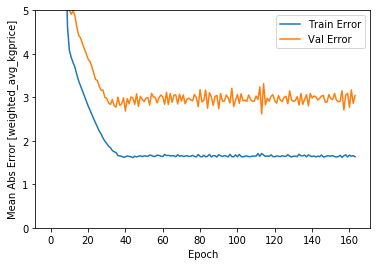

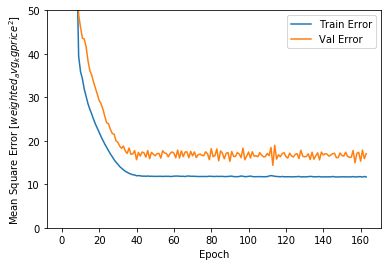

In [38]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
    plt.ylim([0, 50])
    plt.legend()
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [weighted_avg_kgprice]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0, 5])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$weighted_avg_kgprice^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0, 50])
    plt.legend()
  
    plt.show()


plot_history(history)

In [27]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(normed_train_data, labels_train, epochs=1000, batch_size=50, verbose=0, callbacks=[early_stop, checkpoint], validation_split=0.2)


Epoch 00001: val_loss did not improve from 13.32981

Epoch 00002: val_loss did not improve from 13.32981

Epoch 00003: val_loss did not improve from 13.32981

Epoch 00004: val_loss did not improve from 13.32981

Epoch 00005: val_loss did not improve from 13.32981

Epoch 00006: val_loss did not improve from 13.32981

Epoch 00007: val_loss did not improve from 13.32981

Epoch 00008: val_loss did not improve from 13.32981

Epoch 00009: val_loss did not improve from 13.32981

Epoch 00010: val_loss did not improve from 13.32981

Epoch 00011: val_loss did not improve from 13.32981

Epoch 00012: val_loss did not improve from 13.32981

Epoch 00013: val_loss did not improve from 13.32981

Epoch 00014: val_loss did not improve from 13.32981

Epoch 00015: val_loss did not improve from 13.32981

Epoch 00016: val_loss did not improve from 13.32981

Epoch 00017: val_loss did not improve from 13.32981

Epoch 00018: val_loss did not improve from 13.32981

Epoch 00019: val_loss did not improve from 13


Epoch 00159: val_loss did not improve from 13.32981

Epoch 00160: val_loss did not improve from 13.32981

Epoch 00161: val_loss did not improve from 13.32981

Epoch 00162: val_loss did not improve from 13.32981

Epoch 00163: val_loss did not improve from 13.32981

Epoch 00164: val_loss did not improve from 13.32981


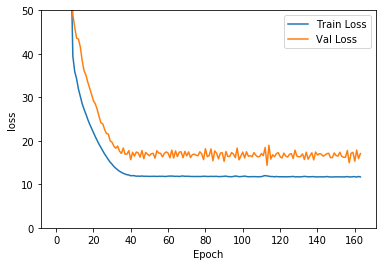

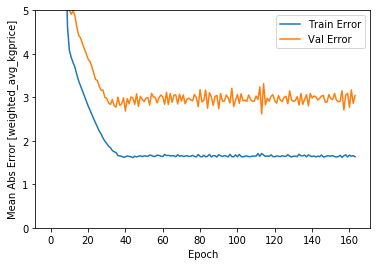

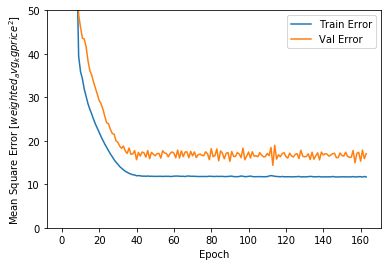

In [39]:
plot_history(history)

In [33]:
loss, mae, mse = model.evaluate(normed_test_data, labels_test, verbose=1)
print("loss: {:5.2f} ".format(loss))
print("mse: {:5.2f} ".format(mse))
print("Testing set Mean Abs Error: {:5.2f} weighted_avg_kgprice".format(mae))
#print(loss)

61/61 [==============================] - 0s 98us/step
loss: 61.35 
mse: 61.35 
Testing set Mean Abs Error:  6.31 weighted_avg_kgprice


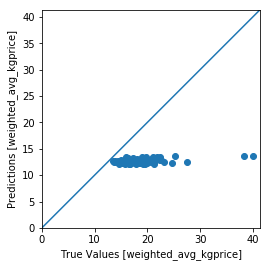

In [34]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(labels_test, test_predictions)
plt.xlabel('True Values [weighted_avg_kgprice]')
plt.ylabel('Predictions [weighted_avg_kgprice]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

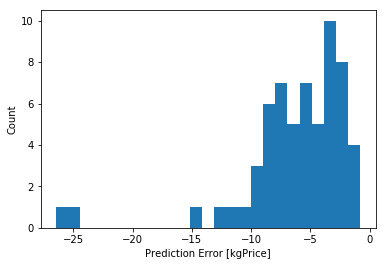

In [35]:
error = test_predictions - labels_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [kgPrice]")
_ = plt.ylabel("Count")

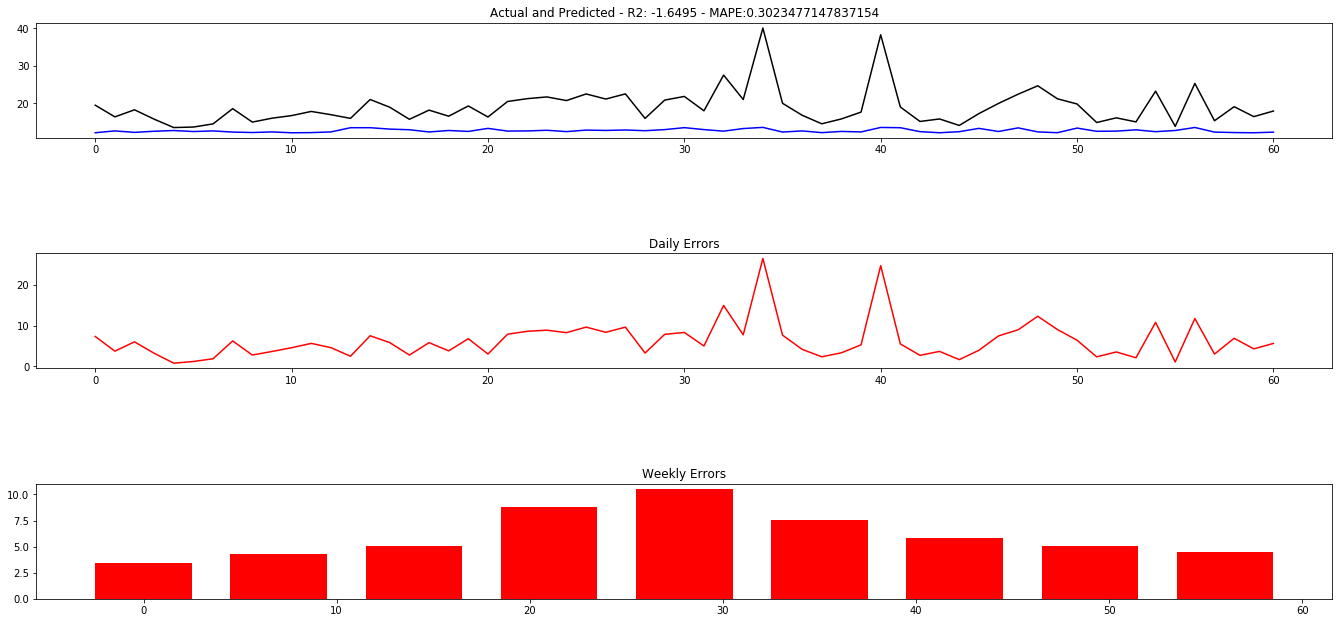

In [36]:
actual = []
for x in range(0, len(labels_test)):
    actual.append(labels_test.iloc[x])

actual = np.asarray(actual, dtype=np.float32)

plot_prediction(actual, test_predictions)

In [37]:
test_predictions = model.predict(normed_test_data).flatten()
print("Predicted \t True value")
for x in range(0, len(test_predictions)):
  print("{:.3f} \t\t {:.3f}".format(test_predictions[x], labels_test.iloc[x])) 
  #print("True value: {}".format(labels_test.iloc[x])) 
#print(test_predictions)

Predicted 	 True value
12.156 		 19.488
12.643 		 16.380
12.249 		 18.263
12.553 		 15.767
12.745 		 13.534
12.473 		 13.672
12.638 		 14.507
12.330 		 18.567
12.212 		 14.991
12.372 		 16.024
12.147 		 16.718
12.187 		 17.826
12.371 		 16.964
13.493 		 15.980
13.493 		 21.000
13.122 		 18.944
12.953 		 15.733
12.360 		 18.174
12.754 		 16.558
12.503 		 19.287
13.313 		 16.345
12.594 		 20.478
12.633 		 21.228
12.811 		 21.688
12.457 		 20.723
12.858 		 22.484
12.769 		 21.126
12.884 		 22.500
12.695 		 15.971
12.989 		 20.843
13.507 		 21.822
12.996 		 17.996
12.571 		 27.503
13.268 		 21.001
13.579 		 40.035
12.343 		 20.000
12.636 		 16.809
12.182 		 14.537
12.504 		 15.833
12.371 		 17.648
13.561 		 38.246
13.493 		 19.008
12.445 		 15.158
12.150 		 15.825
12.438 		 14.098
13.313 		 17.249
12.488 		 19.960
13.448 		 22.420
12.378 		 24.660
12.164 		 21.193
13.394 		 19.812
12.535 		 14.876
12.588 		 16.122
12.926 		 15.043
12.438 		 23.226
12.754 		 13.847
13.552 		 25.276
12.324 	